## **Importing Libraries**

A library was built with the name tfqml.py to store all the dependencies, classes and methods that are used in this work, these classes are
- ClassicalPreprocessing,
- QuantumPreprocessing,
- CircuitLayer,
- QuantumModel-

together with the methods 
- visualization and 
- save_data


the dependencies are:
- numpy 
- pandas 
- matplotlib
- sklearn
- cirq
- tensorflow_quantum
- tensorflow
- sympy

In [1]:
from tfqml import *

2022-02-25 12:47:25.258391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 12:47:25.258410: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-02-25 12:47:26.471731: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-25 12:47:26.471752: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (toto): /proc/driver/nvidia/version does not exist
2022-02-25 12:47:26.472004: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To en

## Compare the classical and quantum with a minimal use

In order to compare our hybrid proposal with respect to a classical model, we used the minimum possible number of parameters and using 3 layers for each model, in the case of the quantum model the first layer is quantum.

In [2]:
## Choose the 8 stocks

name_stocks = ['AAPL','ABB','ABBV','TOT','WMT','DUK','CHL','HSBC']

for name in name_stocks:
    #classical Preprocessing

    cp = ClassicalPreprocessing(filename=name)
    days = 30
    x_train,y_train,x_test,y_test = cp.preprocessing(days=days,flag_pca=False)


    # quantum preprocessing covnert input data to quantum circuit
    qp = QuantumPreprocessing(x_train,x_test)
    x_trainq,x_testq = qp.data2qubits()


    # design an ansatz
    qubits_required = days//3
    qm = QuantumModel(qubits_required)
    model_circuit, model_readout =qm.quantum_circuit([cirq.Y,cirq.X])
    SVGCircuit(model_circuit)

    # create our hybrid model
    # Build the Keras model.
    model = tf.keras.Sequential([
        # The input is the data-circuit, encoded as a tf.string
        tf.keras.layers.Input(shape=(), dtype=tf.string),
        # The PQC layer returns the expected value of the readout gate, range [-1,1].
        tfq.layers.PQC(model_circuit, model_readout),
        tf.keras.layers.Reshape((1,10)),
        tf.keras.layers.LSTM(units=1),
        tf.keras.layers.Dense(units=1),

    ])
    model.compile(
        loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    
    #fit and evaluate our hybrid model
    qnn_history = model.fit(x_trainq, y_train,
      batch_size=32,
      epochs=60)

    qnn_results = model.evaluate(x_testq, y_test)

    #evalute the model
    model.save_weights('qml_minimal_weights_'+name+'_train.h5')
    qnn_results_train = model.evaluate(x_trainq, y_train)
    qnn_results_test = model.evaluate(x_testq, y_test)
    
    #classical part
    #design model
    classical_model = Sequential([
    tf.keras.layers.LSTM(units=3, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=1),
    tf.keras.layers.Dense(units=1),
    ])
    classical_model.compile(loss='mean_squared_error', optimizer='adam')
    
    
    #reshape the dataset
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    #fit and save classical model
    classical_model.fit(x_train, y_train, epochs=60, batch_size=32)
    classical_model.save_weights('stock_minimal_classical_'+name+'_prediction.h5')


Shape of train data: (880, 1)
Shape of test data: (378, 1)
Epoch 1/60
27/27 [==============================] - 4s 94ms/step - loss: 0.2390 - root_mean_squared_error: 0.4888
Epoch 2/60
27/27 [==============================] - 3s 94ms/step - loss: 0.1793 - root_mean_squared_error: 0.4234
Epoch 3/60
27/27 [==============================] - 3s 97ms/step - loss: 0.1263 - root_mean_squared_error: 0.3554
Epoch 4/60
27/27 [==============================] - 3s 96ms/step - loss: 0.0837 - root_mean_squared_error: 0.2893
Epoch 5/60
27/27 [==============================] - 3s 95ms/step - loss: 0.0522 - root_mean_squared_error: 0.2284
Epoch 6/60
27/27 [==============================] - 3s 98ms/step - loss: 0.0324 - root_mean_squared_error: 0.1800
Epoch 7/60
27/27 [==============================] - 3s 92ms/step - loss: 0.0208 - root_mean_squared_error: 0.1442
Epoch 8/60
27/27 [==============================] - 2s 92ms/step - loss: 0.0143 - root_mean_squared_error: 0.1196
Epoch 9/60
27/27 [===========

27/27 [==============================] - 0s 16ms/step - loss: 0.0142
Epoch 13/60
27/27 [==============================] - 0s 18ms/step - loss: 0.0129
Epoch 14/60
27/27 [==============================] - 0s 17ms/step - loss: 0.0121
Epoch 15/60
27/27 [==============================] - 0s 16ms/step - loss: 0.0116
Epoch 16/60
27/27 [==============================] - 0s 17ms/step - loss: 0.0109
Epoch 17/60
27/27 [==============================] - 0s 16ms/step - loss: 0.0105
Epoch 18/60
27/27 [==============================] - 0s 16ms/step - loss: 0.0106
Epoch 19/60
27/27 [==============================] - 0s 16ms/step - loss: 0.0104
Epoch 20/60
27/27 [==============================] - 0s 16ms/step - loss: 0.0097
Epoch 21/60
27/27 [==============================] - 0s 16ms/step - loss: 0.0097
Epoch 22/60
27/27 [==============================] - 0s 17ms/step - loss: 0.0092
Epoch 23/60
27/27 [==============================] - 0s 17ms/step - loss: 0.0093
Epoch 24/60
27/27 [=====================

27/27 [==============================] - 3s 93ms/step - loss: 0.0024 - root_mean_squared_error: 0.0486
Epoch 38/60
27/27 [==============================] - 3s 98ms/step - loss: 0.0023 - root_mean_squared_error: 0.0482
Epoch 39/60
27/27 [==============================] - 3s 98ms/step - loss: 0.0023 - root_mean_squared_error: 0.0478
Epoch 40/60
27/27 [==============================] - 2s 92ms/step - loss: 0.0022 - root_mean_squared_error: 0.0473
Epoch 41/60
27/27 [==============================] - 3s 94ms/step - loss: 0.0022 - root_mean_squared_error: 0.0469
Epoch 42/60
27/27 [==============================] - 3s 93ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466
Epoch 43/60
27/27 [==============================] - 3s 97ms/step - loss: 0.0021 - root_mean_squared_error: 0.0463
Epoch 44/60
27/27 [==============================] - 3s 96ms/step - loss: 0.0021 - root_mean_squared_error: 0.0461
Epoch 45/60
27/27 [==============================] - 3s 97ms/step - loss: 0.0021 - root_mean

25/25 [==============================] - 3s 101ms/step - loss: 0.3035 - root_mean_squared_error: 0.5509
Epoch 3/60
25/25 [==============================] - 2s 93ms/step - loss: 0.2398 - root_mean_squared_error: 0.4897
Epoch 4/60
25/25 [==============================] - 2s 97ms/step - loss: 0.1776 - root_mean_squared_error: 0.4214
Epoch 5/60
25/25 [==============================] - 3s 106ms/step - loss: 0.1181 - root_mean_squared_error: 0.3436
Epoch 6/60
25/25 [==============================] - 3s 105ms/step - loss: 0.0707 - root_mean_squared_error: 0.2658
Epoch 7/60
25/25 [==============================] - 2s 97ms/step - loss: 0.0409 - root_mean_squared_error: 0.2022
Epoch 8/60
25/25 [==============================] - 2s 95ms/step - loss: 0.0249 - root_mean_squared_error: 0.1579
Epoch 9/60
25/25 [==============================] - 3s 106ms/step - loss: 0.0167 - root_mean_squared_error: 0.1293
Epoch 10/60
25/25 [==============================] - 3s 104ms/step - loss: 0.0125 - root_mean_s

25/25 [==============================] - 0s 15ms/step - loss: 0.0449
Epoch 15/60
25/25 [==============================] - 0s 19ms/step - loss: 0.0423
Epoch 16/60
25/25 [==============================] - 0s 14ms/step - loss: 0.0391
Epoch 17/60
25/25 [==============================] - 0s 18ms/step - loss: 0.0323
Epoch 18/60
25/25 [==============================] - 0s 15ms/step - loss: 0.0265
Epoch 19/60
25/25 [==============================] - 0s 16ms/step - loss: 0.0241
Epoch 20/60
25/25 [==============================] - 0s 20ms/step - loss: 0.0207
Epoch 21/60
25/25 [==============================] - 0s 18ms/step - loss: 0.0206
Epoch 22/60
25/25 [==============================] - 0s 16ms/step - loss: 0.0219
Epoch 23/60
25/25 [==============================] - 1s 23ms/step - loss: 0.0206
Epoch 24/60
25/25 [==============================] - 0s 14ms/step - loss: 0.0213
Epoch 25/60
25/25 [==============================] - 0s 16ms/step - loss: 0.0201
Epoch 26/60
25/25 [=====================

27/27 [==============================] - 3s 93ms/step - loss: 0.0032 - root_mean_squared_error: 0.0564
Epoch 39/60
27/27 [==============================] - 3s 104ms/step - loss: 0.0031 - root_mean_squared_error: 0.0561
Epoch 40/60
27/27 [==============================] - 3s 92ms/step - loss: 0.0031 - root_mean_squared_error: 0.0558
Epoch 41/60
27/27 [==============================] - 3s 98ms/step - loss: 0.0031 - root_mean_squared_error: 0.0554
Epoch 42/60
27/27 [==============================] - 3s 93ms/step - loss: 0.0030 - root_mean_squared_error: 0.0552
Epoch 43/60
27/27 [==============================] - 3s 95ms/step - loss: 0.0030 - root_mean_squared_error: 0.0549
Epoch 44/60
27/27 [==============================] - 3s 110ms/step - loss: 0.0030 - root_mean_squared_error: 0.0547
Epoch 45/60
27/27 [==============================] - 3s 97ms/step - loss: 0.0030 - root_mean_squared_error: 0.0544
Epoch 46/60
27/27 [==============================] - 2s 92ms/step - loss: 0.0029 - root_me

27/27 [==============================] - 2s 92ms/step - loss: 0.1040 - root_mean_squared_error: 0.3225
Epoch 4/60
27/27 [==============================] - 3s 98ms/step - loss: 0.0607 - root_mean_squared_error: 0.2464
Epoch 5/60
27/27 [==============================] - 3s 98ms/step - loss: 0.0360 - root_mean_squared_error: 0.1896
Epoch 6/60
27/27 [==============================] - 3s 100ms/step - loss: 0.0238 - root_mean_squared_error: 0.1543
Epoch 7/60
27/27 [==============================] - 3s 95ms/step - loss: 0.0185 - root_mean_squared_error: 0.1361
Epoch 8/60
27/27 [==============================] - 3s 98ms/step - loss: 0.0161 - root_mean_squared_error: 0.1270
Epoch 9/60
27/27 [==============================] - 3s 96ms/step - loss: 0.0146 - root_mean_squared_error: 0.1207
Epoch 10/60
27/27 [==============================] - 3s 97ms/step - loss: 0.0135 - root_mean_squared_error: 0.1161
Epoch 11/60
27/27 [==============================] - 2s 85ms/step - loss: 0.0126 - root_mean_squa

Epoch 15/60
27/27 [==============================] - 0s 14ms/step - loss: 0.0088
Epoch 16/60
27/27 [==============================] - 0s 16ms/step - loss: 0.0080
Epoch 17/60
27/27 [==============================] - 0s 12ms/step - loss: 0.0081
Epoch 18/60
27/27 [==============================] - 0s 11ms/step - loss: 0.0074
Epoch 19/60
27/27 [==============================] - 0s 11ms/step - loss: 0.0072
Epoch 20/60
27/27 [==============================] - 0s 15ms/step - loss: 0.0070
Epoch 21/60
27/27 [==============================] - 0s 16ms/step - loss: 0.0068
Epoch 22/60
27/27 [==============================] - 0s 13ms/step - loss: 0.0065
Epoch 23/60
27/27 [==============================] - 0s 16ms/step - loss: 0.0059
Epoch 24/60
27/27 [==============================] - 0s 14ms/step - loss: 0.0058
Epoch 25/60
27/27 [==============================] - 0s 15ms/step - loss: 0.0056
Epoch 26/60
27/27 [==============================] - 0s 14ms/step - loss: 0.0053
Epoch 27/60
27/27 [=========

27/27 [==============================] - 2s 89ms/step - loss: 0.0028 - root_mean_squared_error: 0.0527
Epoch 40/60
27/27 [==============================] - 3s 95ms/step - loss: 0.0027 - root_mean_squared_error: 0.0519
Epoch 41/60
27/27 [==============================] - 3s 92ms/step - loss: 0.0026 - root_mean_squared_error: 0.0513
Epoch 42/60
27/27 [==============================] - 3s 94ms/step - loss: 0.0026 - root_mean_squared_error: 0.0507
Epoch 43/60
27/27 [==============================] - 3s 96ms/step - loss: 0.0025 - root_mean_squared_error: 0.0501
Epoch 44/60
27/27 [==============================] - 3s 92ms/step - loss: 0.0025 - root_mean_squared_error: 0.0496
Epoch 45/60
27/27 [==============================] - 3s 100ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491
Epoch 46/60
27/27 [==============================] - 3s 101ms/step - loss: 0.0024 - root_mean_squared_error: 0.0487
Epoch 47/60
27/27 [==============================] - 3s 105ms/step - loss: 0.0023 - root_m

27/27 [==============================] - 2s 93ms/step - loss: 0.1289 - root_mean_squared_error: 0.3591
Epoch 5/60
27/27 [==============================] - 2s 93ms/step - loss: 0.1027 - root_mean_squared_error: 0.3204
Epoch 6/60
27/27 [==============================] - 2s 92ms/step - loss: 0.0811 - root_mean_squared_error: 0.2847
Epoch 7/60
27/27 [==============================] - 3s 94ms/step - loss: 0.0638 - root_mean_squared_error: 0.2526
Epoch 8/60
27/27 [==============================] - 3s 96ms/step - loss: 0.0509 - root_mean_squared_error: 0.2255
Epoch 9/60
27/27 [==============================] - 3s 94ms/step - loss: 0.0412 - root_mean_squared_error: 0.2029
Epoch 10/60
27/27 [==============================] - 3s 93ms/step - loss: 0.0340 - root_mean_squared_error: 0.1843
Epoch 11/60
27/27 [==============================] - 2s 92ms/step - loss: 0.0285 - root_mean_squared_error: 0.1689
Epoch 12/60
27/27 [==============================] - 2s 92ms/step - loss: 0.0245 - root_mean_squa

27/27 [==============================] - 0s 12ms/step - loss: 0.0048
Epoch 18/60
27/27 [==============================] - 0s 13ms/step - loss: 0.0047
Epoch 19/60
27/27 [==============================] - 0s 13ms/step - loss: 0.0046
Epoch 20/60
27/27 [==============================] - 0s 12ms/step - loss: 0.0042
Epoch 21/60
27/27 [==============================] - 0s 16ms/step - loss: 0.0041
Epoch 22/60
27/27 [==============================] - 0s 12ms/step - loss: 0.0040
Epoch 23/60
27/27 [==============================] - 0s 13ms/step - loss: 0.0042
Epoch 24/60
27/27 [==============================] - 0s 15ms/step - loss: 0.0039
Epoch 25/60
27/27 [==============================] - 0s 15ms/step - loss: 0.0036
Epoch 26/60
27/27 [==============================] - 0s 12ms/step - loss: 0.0041
Epoch 27/60
27/27 [==============================] - 0s 12ms/step - loss: 0.0043
Epoch 28/60
27/27 [==============================] - 0s 12ms/step - loss: 0.0036
Epoch 29/60
27/27 [=====================

27/27 [==============================] - 3s 96ms/step - loss: 0.0050 - root_mean_squared_error: 0.0704
Epoch 41/60
27/27 [==============================] - 3s 93ms/step - loss: 0.0049 - root_mean_squared_error: 0.0697
Epoch 42/60
27/27 [==============================] - 3s 98ms/step - loss: 0.0048 - root_mean_squared_error: 0.0689
Epoch 43/60
27/27 [==============================] - 2s 91ms/step - loss: 0.0046 - root_mean_squared_error: 0.0682
Epoch 44/60
27/27 [==============================] - 3s 96ms/step - loss: 0.0046 - root_mean_squared_error: 0.0675
Epoch 45/60
27/27 [==============================] - 3s 96ms/step - loss: 0.0045 - root_mean_squared_error: 0.0668
Epoch 46/60
27/27 [==============================] - 3s 98ms/step - loss: 0.0044 - root_mean_squared_error: 0.0661
Epoch 47/60
27/27 [==============================] - 2s 92ms/step - loss: 0.0043 - root_mean_squared_error: 0.0654
Epoch 48/60
27/27 [==============================] - 3s 102ms/step - loss: 0.0042 - root_mea

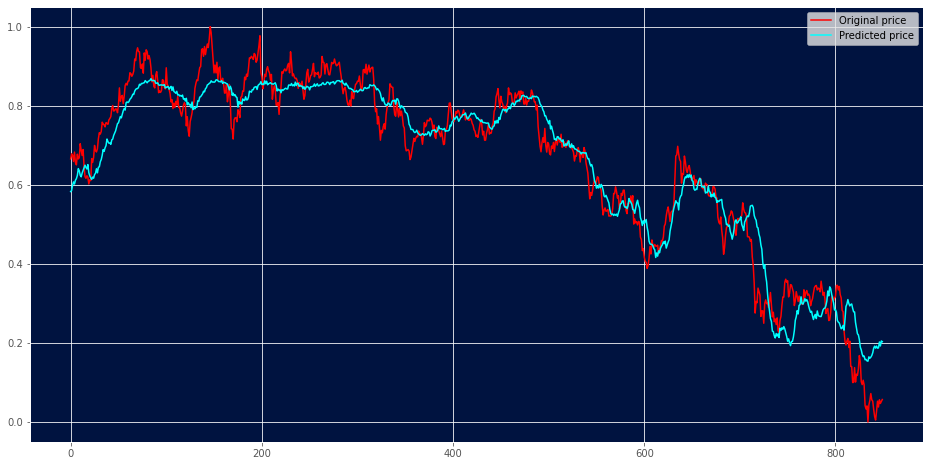

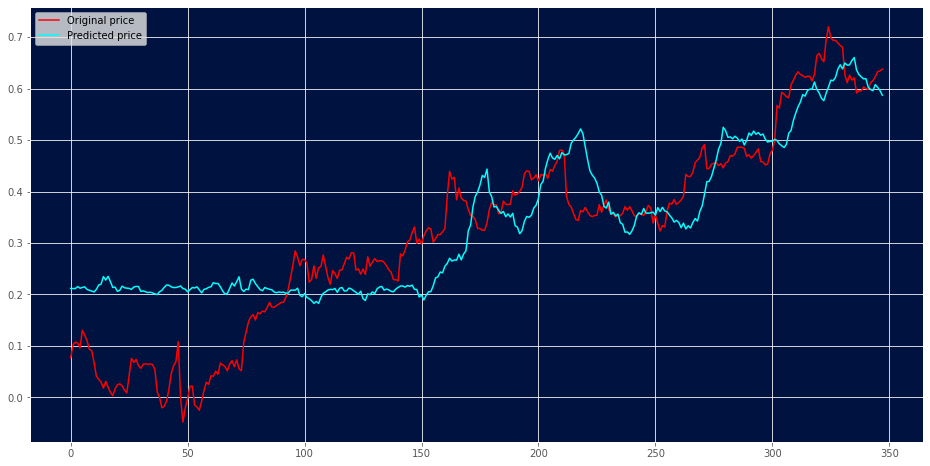

In [3]:
visualization(model,x_trainq,y_train)
visualization(model,x_testq,y_test)

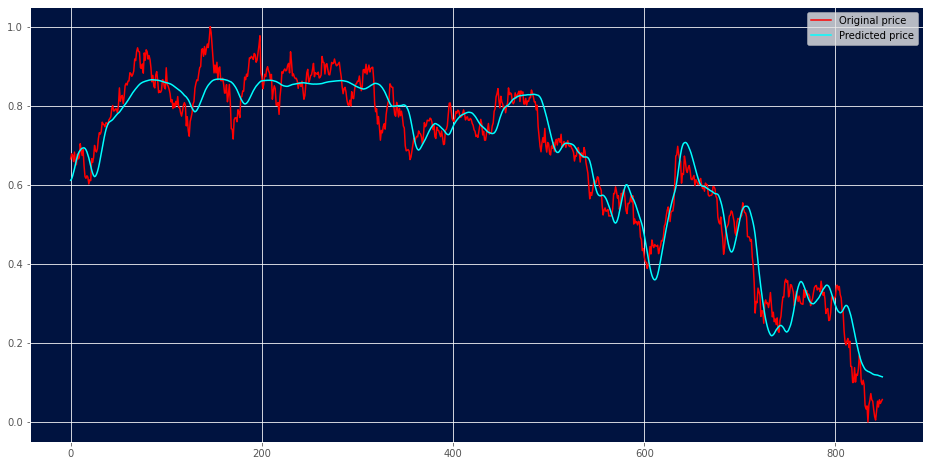

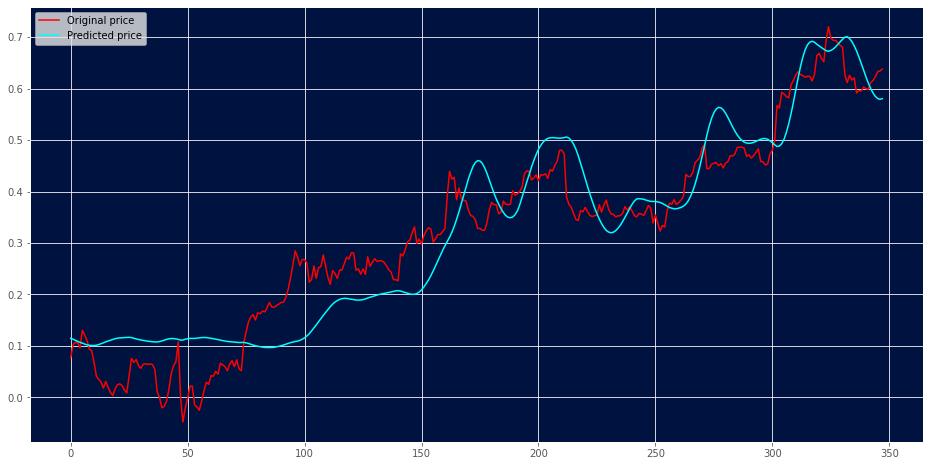

In [4]:
visualization(classical_model,x_train,y_train)
visualization(classical_model,x_test,y_test)

In [5]:
print("quantum","classical")
list_error_c = []
list_error_q = []
for name in name_stocks:
    model.load_weights('qml_minimal_weights_'+name+'_train.h5')
    classical_model.load_weights('stock_minimal_classical_'+name+'_prediction.h5')

    predictions = model.predict(x_trainq)
    train_predictions = predictions.reshape(len(y_train),1)

    c_predictions = classical_model.predict(x_train)
    train_c_predictions = c_predictions.reshape(len(y_train),1)


    predictions = model.predict(x_testq)
    test_predictions = predictions.reshape(len(y_test),1)

    c_predictions = classical_model.predict(x_test)
    test_c_predictions = c_predictions.reshape(len(y_test),1)
    print("train: ",mean_absolute_error(y_train, train_predictions)*100,mean_absolute_error(y_train, train_c_predictions)*100)

    print("test: ",mean_absolute_error(y_test, test_predictions)*100,mean_absolute_error(y_test, test_c_predictions)*100)
    print()
    list_error_c.append([mean_absolute_error(y_train, train_c_predictions)*100,mean_absolute_error(y_test, test_c_predictions)*100])
    list_error_q.append([mean_absolute_error(y_train, train_predictions)*100,mean_absolute_error(y_test, test_predictions)*100])
    

quantum classical
train:  3.4985605589552273 4.341641623373906
test:  3.5699167337967257 4.746031319274454

train:  3.124789936990579 4.034601377229078
test:  3.102233515498372 3.751406313613506

train:  3.9230274837602255 4.251283690583223
test:  4.862838530757652 4.654430744732195

train:  3.6469756932105315 3.487781559229184
test:  3.671801568759905 3.147849974567

train:  3.577528410119098 3.8396250470359488
test:  3.3934347561715588 3.644913969891992

train:  4.095764829178897 3.856108524490872
test:  3.9840433386822007 4.195547997722662

train:  5.811380640996595 3.92130462691199
test:  3.508787676950593 3.422907186246433

train:  4.400224717234666 4.098954873335043
test:  7.820905499789562 5.923856279813257



In [6]:
from IPython.display import HTML
df_result = pd.DataFrame(list_error_c,columns =['Error train (%)','Error test (%)'],)
HTML(df_result.to_html(index=False))

Error train (%),Error test (%)
4.341642,4.746031
4.034601,3.751406
4.251284,4.654431
3.487782,3.147850
3.839625,3.644914
3.856109,4.195548
3.921305,3.422907
4.098955,5.923856


In [7]:
from IPython.display import HTML
df_result = pd.DataFrame(list_error_q,columns =['Error train (%)','Error test (%)'],)
HTML(df_result.to_html(index=False))

Error train (%),Error test (%)
3.498561,3.569917
3.124790,3.102234
3.923027,4.862839
3.646976,3.671802
3.577528,3.393435
4.095765,3.984043
5.811381,3.508788
4.400225,7.820905
